# Checklist
* Dodać checkpointowanie
* Dodać macierz pomyłek do TB
* Zrobić zapis testu jednostkowego do pliku

#Python - instalacja modułów

In [2]:
%%shell
pip install hydra-core --upgrade --quiet
pip install unzip --quiet
pip install ipdb -Uqq
pip install pytorch-lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.8/775.8 KB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 KB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 53.5 MB/s eta 0:00:00
   

#Python - import pakietów

In [3]:
# standardowe pakiety
import os
from os.path import join

import numpy as np

import scipy as sp
from scipy import array, newaxis

#from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import glob
import ipdb
from __future__ import print_function
from tqdm import tqdm

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torch.utils.data as data
import torchmetrics
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.profilers import PyTorchProfiler

# Hydra
import hydra
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

# tensorboard
#from sklearn.metrics import confusion_matrix
import pandas as pd
#from torch.utils.tensorboard import SummaryWriter 
import seaborn as sn
import io
from PIL import Image
from torchmetrics import ConfusionMatrix


#Generacja plików konfiguracyjnych Hydra

Aby załadować checkpoint modelu należy w pliku classification.yaml podać jako parametr `model_pretrained` ścieżkę do załadowanego pliku `model_pretrained.ckpt` oraz ustawić wartość `pretrained` na `True`

In [4]:
os.environ['HYDRA_DIR'] = "/content/hydraConfs"

In [37]:
%%shell

mkdir ${HYDRA_DIR}

echo "name: classification
batch_size:               32
num_points:               512
cleaned_dataset:          False
dataset:                  'ModelNet40'
train_with_own:           True
pretrained:               True
model_pretrained:         "/content/model_pretrained.ckpt"
single_batch_overfit:     False" > ${HYDRA_DIR}/classification.yaml

echo "name: pl_trainer
check_val_every_n_epoch:  1
num_sanity_val_steps:     5
accelerator:              'gpu'
devices:                  1
auto_select_gpus:         True 
max_epochs:               20
auto_scale_batch_size:    False 
amp_backend:              'native'
benchmark:                False 
overfit_batches:          0" > ${HYDRA_DIR}/pl_trainer.yaml

echo "name: optimizer
optimizer:                'Adam'
lr:                       0.01
betas:                    [0.9, 0.999]" > ${HYDRA_DIR}/optimizer.yaml

echo "name: scheduler
scheduler:                'StepLR'
step_size:                20
gamma:                    0.5" > ${HYDRA_DIR}/scheduler.yaml

mkdir: cannot create directory ‘/content/hydraConfs’: File exists


In [34]:
hydra_dir = os.environ.get('HYDRA_DIR')

confClass = OmegaConf.load(hydra_dir + "/classification.yaml")
confTrainer = OmegaConf.load(hydra_dir + "/pl_trainer.yaml")
confOptim = OmegaConf.load(hydra_dir + "/optimizer.yaml")
confSched = OmegaConf.load(hydra_dir + "/scheduler.yaml")

options = instantiate(confClass)
optionsTrainer = instantiate(confTrainer)
optionsOptim = instantiate(confOptim)
optionsSched = instantiate(confSched)

#Pobieranie danych

In [7]:
if not options.cleaned_dataset:
    ! wget -O modelnet40-normal_numpy.tar.zip https://box.skoltech.ru/index.php/s/dXgCWvAcYjgd7FC/download
    ! unzip modelnet40-normal_numpy.tar.zip > /dev/null
    ! rm modelnet40-normal_numpy.tar.zip > /dev/null
    ! tar -xvf modelnet40-normal_numpy.tar > /dev/null
    dataset_num_classes = 40
    dataset_root = '/content/modelnet40-normal_numpy/'
else:
    if options.dataset == 'ModelNet40':
        ! wget http://modelnet.cs.princeton.edu/ModelNet40.zip
        ! unzip -qq /content/ModelNet40.zip -d /content/
        dataset_num_classes = 40
        dataset_root = '/content/ModelNet40/'
    elif options.dataset == 'ModelNet10':
        ! wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
        ! unzip -qq /content/ModelNet10.zip -d /content/
        dataset_num_classes = 10
        dataset_root = '/content/ModelNet10/'
    else:
        raise ValueError("Wrong model name!")

--2023-01-05 13:05:39--  https://box.skoltech.ru/index.php/s/dXgCWvAcYjgd7FC/download
Resolving box.skoltech.ru (box.skoltech.ru)... 195.133.216.199
Connecting to box.skoltech.ru (box.skoltech.ru)|195.133.216.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1732629450 (1.6G) [application/zip]
Saving to: ‘modelnet40-normal_numpy.tar.zip’

modelnet40-normal_n 100%[===================>]   1.61G  5.27MB/s    in 5m 22s  

2023-01-05 13:11:02 (5.14 MB/s) - ‘modelnet40-normal_numpy.tar.zip’ saved [1732629450/1732629450]



#Obsługa danych

##Dataset (PyTorch)

In [8]:
class ModelNetDataset(data.Dataset):
    def __init__(self, root, randomize_pts=True, load_faces=False, split='train', num_classes=40, numpoints=5000, batch_size=32):
        self.root = root
        self.numpoints = numpoints
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.randomize_pts = randomize_pts
        self.load_faces = load_faces
        self.filelist = [f1 for f1 in glob.glob(self.root + '**/*.off', recursive=True)]
        self.trainlist = [f2 for f2 in self.filelist if "train" in f2]
        self.testlist = [f3 for f3 in self.filelist if "test" in f3]
        if split=='train': self.objlist = self.flist_reader(self.trainlist)
        if split=='test': self.objlist = self.flist_reader(self.testlist)

    def __getitem__(self, index):
        impath, target = self.objlist[index]
        myF = open(impath, 'r')
        firstLine = myF.readline().strip()
        if 'OFF' != firstLine[0:3]:
            raise ValueError('Not a valid OFF header')
        if len(firstLine) > 3:
            n_verts, n_faces, n_edges = tuple([int(s) for s in firstLine[3:].split(' ')])
        else:
            n_verts, n_faces, n_edges = tuple([int(s) for s in myF.readline().strip().split(' ')])
        verts = np.array([[float(s) for s in myF.readline().strip().split(' ')] for i_vert in range(n_verts)])
        choice = np.random.choice(verts.shape[0], self.numpoints, replace=True)
        if self.randomize_pts:
          point_set = verts[choice, :]
        else:
          point_set = verts
        
        point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0) 
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
        point_set = point_set / dist  
        
        point_set = torch.from_numpy(point_set.astype(np.float32)).float()

        if self.load_faces:
            faces = np.array([[int(s) for s in myF.readline().strip().split(' ')][1:] for i_face in range(n_faces)])
            return point_set, target, faces
        else:
            return point_set, target

    def flist_reader(self, filelist):
        classes_dirs = glob.glob(self.root + "*/", recursive = False)
        classes_list = [i.split('/')[3] for i in classes_dirs]
        classes_nums = np.linspace(0,self.num_classes-1,self.num_classes)
        self.classes_dict = dict(zip(sorted(classes_list), classes_nums.astype(int)))
        self.nums_dict = dict(map(reversed, self.classes_dict.items()))
        objlist = []

        for line in filelist:
            label_start_index = line.strip().find(self.root) + len(self.root)
            label_end_index = line.strip()[label_start_index:].find('/')
            imlabel = line.strip()[label_start_index:label_start_index+label_end_index]
            imlabel = self.classes_dict[imlabel]
            impath = line
            objlist.append( (impath, imlabel) )
        return objlist

    def __len__(self):
      return len(self.objlist)

In [9]:
class ModelNetDatasetNP(data.Dataset):
    def __init__(self, root, randomize_pts=True, load_faces=False, split='train', num_classes=40, numpoints=5000, batch_size=32):
        self.root = root
        self.numpoints = numpoints
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.randomize_pts = randomize_pts
        self.load_faces = load_faces
        self.test_file = open(self.root + "modelnet40_test.txt", "r")
        self.train_file = open(self.root + "modelnet40_train.txt", "r")
        if split=='train': 
            self.objlistNoClass = self.train_file.read().replace('\n', ' ').split(" ")
        if split=='test': 
            self.objlistNoClass = self.test_file.read().replace('\n', ' ').split(" ")

        self.classlist = [item[:-5] for item in self.objlistNoClass]
        self.objlist = tuple(zip(self.objlistNoClass, self.classlist))[:-1]

        self.classes_file = open(self.root + "modelnet40_shape_names.txt", "r")
        self.classes_list = self.classes_file.read().replace('\n', ' ').split(" ")[:-1]
        self.classes_nums = np.linspace(0,self.num_classes-1,self.num_classes)
        self.classes_dict = dict(zip(sorted(self.classes_list), self.classes_nums.astype(int)))
        self.nums_dict = dict(map(reversed, self.classes_dict.items()))

    def __getitem__(self, index):
        impath, target = self.objlist[index]
        try:
            array =  np.load(self.root + target + "/" + impath + ".npy")
        except FileNotFoundError:
            print("Znaleziono błąd")
            print(index)
        point_set = array[:, :3]
        if self.randomize_pts:
            choice = np.random.choice(point_set.shape[0], self.numpoints, replace=True)
            point_set = point_set[choice, :]
        
        point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0) 
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
        point_set = point_set / dist  
        
        point_set = torch.from_numpy(point_set.astype(np.float32)).float()
        target = self.classes_dict[target]
        return point_set, target

    def __len__(self):
        return len(self.objlist)

##Datamodule (PyTorch Lightning)


In [10]:
class ModelNetDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        if options.cleaned_dataset:
            self.datasetClass = ModelNetDataset
        else:
            self.datasetClass = ModelNetDatasetNP

    def prepare_data(self):
        pass
        #funkcja celowo pozostawiona pusta - pobieranie danycn jest na początku notatnika, zaś obsługa danych w klasie ModelNetDataset
        
    def setup(self, stage = None):
        if stage == "fit" or stage is None:
            dataset = self.datasetClass(
                root=dataset_root, 
                num_classes=dataset_num_classes, 
                batch_size=options.batch_size, 
                split='train', 
                numpoints=options.num_points)
            traindataset_size = int(len(dataset) * 0.9)
            valid_set_size = len(dataset) - traindataset_size
            self.traindataset, self.valdataset = random_split(dataset, [traindataset_size, len(dataset) - traindataset_size])

        if stage == "test" or stage is None:
            self.testdataset = self.datasetClass(
                root=dataset_root, 
                num_classes=dataset_num_classes, 
                batch_size=options.batch_size, 
                split='test', 
                numpoints=options.num_points)
            
    def train_dataloader(self):
        return DataLoader(
            self.traindataset, 
            batch_size=options.batch_size, 
            num_workers=4, 
            shuffle=True)

    def val_dataloader(self):
        return DataLoader(
            self.valdataset, 
            batch_size=options.batch_size, 
            num_workers=4, 
            shuffle=False)

    def test_dataloader(self):
        return DataLoader(
            self.testdataset, 
            batch_size=options.batch_size, 
            num_workers=4, 
            shuffle=False)


##Wyświetlanie jednego obiektu

Ilość obiektów w zbiorze: 9843


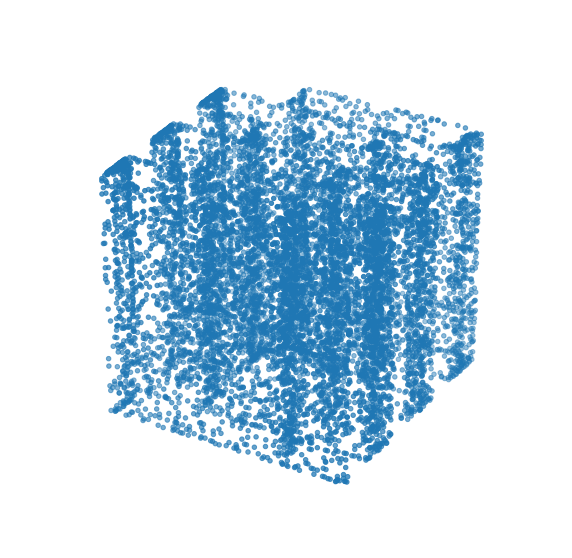

Etykieta klasy: 4
bookshelf



In [13]:
def disp(vertices, target, faces, dataset, full):
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    
    V_np = np.asarray(vertices.cpu())
    if not full:
      ax.scatter(V_np[:, 0], V_np[:, 1], V_np[:, 2])
    else:
      ax.plot_trisurf(V_np[:, 0], V_np[:, 1], V_np[:, 2], triangles=faces);

    plt.axis('off')
    plt.show()
    print('Etykieta klasy: {}'.format(target))
    print(dataset.nums_dict[target])
    print('')
    
#test for all objects
'''
print(len(mdltest))

for n in range(len(mdltest)):
  xxx = mdltest[n]
  if xxx[0].shape[0] == 0:
    ipdb.set_trace(context=5)
'''

#mdltest = ModelNetDataset(root=dataset_root, randomize_pts = False, load_faces=True)
#mdltestR = ModelNetDataset(root=dataset_root, randomize_pts = True, load_faces=True)
mdltestNP = ModelNetDatasetNP(root="/content/modelnet40-normal_numpy/", randomize_pts = False, load_faces=True)

print("Ilość obiektów w zbiorze: {}".format(len(mdltestNP)))
ind = random.randint(0, len(mdltestNP))
#xxx = mdltest[ind]
#xxxR = mdltestR[ind]
xxxNP = mdltestNP[ind]


#disp(xxx[0], xxx[1], xxx[2], mdltest, full=False)
#disp(xxx[0], xxx[1], xxx[2], mdltest, full=True)

disp(xxxNP[0], xxxNP[1], _, mdltestNP, full=False)
#disp(xxxR[0], xxxR[1], xxxR[2], mdltestR, full=False)


#Model

## Model (PyTorch)

In [ ]:
class SmallNet(nn.Module):
      def __init__(self, k=dataset_num_classes):
          super().__init__()
          self.conv1 =  torch.nn.Conv1d(3, 64, 1)
          self.bn1 =    nn.BatchNorm1d(64)
          self.relu =   nn.ReLU()
          self.fn =     nn.Linear(64, k)

      def forward(self, x):
          x = x.transpose(2, 1)
          x = F.relu(self.bn1(self.conv1(x)))
          x = torch.max(x, 2, keepdim=False)[0]
          x = self.fn(x)
          return x

##Model - repo

In [ ]:
class STN(nn.Module):
    def __init__(self, kd=True):
        if kd:  self.k=64; self.iden_arr=np.eye(self.k).flatten()
        else:   self.k=3;  self.iden_arr=np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]) 
        self.kd = kd
        super(STN, self).__init__()
        self.conv1 = torch.nn.Conv1d(self.k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.k*self.k)
        self.relu = nn.ReLU()

        for x in range(5): 
          string= "self.bn" + str(x+1) + "=nn.BatchNorm1d(" + str(64*2**(x)) + ")"
          exec(string)
        
    def forward(self, x):
        if not self.kd: x = x.transpose(2, 1) 
        batchsize = x.shape[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn5(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024) 
        x = F.relu(self.bn4(self.fc1(x))) 
        x = F.relu(self.bn3(self.fc2(x)))
        x = self.fc3(x)
        iden = torch.from_numpy(self.iden_arr.astype(np.float32)).view(1, self.k*self.k).repeat(batchsize, 1)
        if x.is_cuda:
            iden = iden.to(x.device)
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn = STN(kd=False)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.fstn = STN()

    def forward(self, x):
        n_pts = x.shape[2]
        trans = self.stn(x)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        trans_feat = self.fstn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans_feat)
        x = x.transpose(2,1)

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.to(trans.device)
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

class PointNetCls(nn.Module):
    def __init__(self, k=dataset_num_classes):
        super(PointNetCls, self).__init__()
        self.feat = PointNetfeat(global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat

##Model - własny

In [ ]:
np.eye(3).flatten()

array([1., 0., 0., 0., 1., 0., 0., 0., 1.])

In [26]:
class STNk(nn.Module):
    def __init__(self, kd=1):
        self.kd=kd; 
        self.iden_arr=np.eye(self.kd).flatten()
        super().__init__()

        self.conv1 = nn.Conv1d(self.kd, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.kd*self.kd)
        self.relu = nn.ReLU()

        for x in range(5): 
          string= "self.bn" + str(x+1) + "=nn.BatchNorm1d(" + str(64*2**(x)) + ")"
          exec(string)
        
    def forward(self, x):
        if not self.kd==64: x = x.transpose(2, 1) 
        batchsize = x.shape[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn5(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024) 
        x = F.relu(self.bn4(self.fc1(x))) 
        x = F.relu(self.bn3(self.fc2(x)))
        x = self.fc3(x)
        iden = torch.from_numpy(self.iden_arr.astype(np.float32)).view(1, self.kd*self.kd).repeat(batchsize, 1)
        if x.is_cuda:
            iden = iden.to(x.device)
        x = x + iden
        x = x.view(-1, self.kd, self.kd)
        return x

''' TUTAJ BYŁY EKEPERYMENTY Z ILOŚCIĄ WARSTW UKRYTYCH ALE WYKAZAŁY SIE GORSZYM ACC
class MLP_NxM(nn.Module):
  def __init__(self,N=1,M=1,end=False):
        super().__init__()
        self.N = N
        self.M = M
        self.end = end;
        self.conv1 = nn.Conv1d(N, int(M/2), 1)
        self.conv2 = nn.Conv1d(int(M/2), M, 1)
        self.conv1e = nn.Conv1d(N, int(N/2), 1)
        self.conv2e = nn.Conv1d(int(N/2), M, 1)
        self.bn1 = nn.BatchNorm1d(int(M/2))
        self.bn2 = nn.BatchNorm1d(M)

  def forward(self, x):
        if self.end:
          x = x.transpose(0, 1)
          x = F.relu(self.conv1e(x))
          x = self.conv2e(x)
        else:
          x = x.transpose(2,1)
          x = F.relu(self.bn1(self.conv1(x)))
          x = F.relu(self.bn2(self.conv2(x)))
        return x 
'''

class MLP_NxM(nn.Module):
  def __init__(self,N=1,M=1,end=False):
        super().__init__()
        self.N = N
        self.M = M
        self.end = end;
        self.conv1 = nn.Conv1d(N, M, 1)
        self.bn1 = nn.BatchNorm1d(M)

  def forward(self, x):
        #ipdb.set_trace(context=5)
        if self.end:
          x = x.transpose(0, 1)
          x = self.conv1(x)
        else:
          x = x.transpose(2,1)
          x = F.relu(self.bn1(self.conv1(x)))
        return x 

class TopLevelEntity(nn.Module):
  def __init__(self, N=1, M=1, k=dataset_num_classes):
        super().__init__()
        self.MLP_3x64=MLP_NxM(N=3,M=64)
        self.STN3d=STNk(kd=3)
        self.MLP_64x1024=MLP_NxM(N=64,M=1024)
        self.STN64d=STNk(kd=64)
        self.MLP_1024x40=MLP_NxM(N=1024,M=k,end=True)

  def forward(self, x):
        trans = self.STN3d(x)
        x = torch.bmm(x,trans)
        x = self.MLP_3x64(x)
        trans = self.STN64d(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x,trans)
        x = self.MLP_64x1024(x)
        x, _ = torch.max(x,2)
        x = self.MLP_1024x40(x)
        x = x.transpose(0, 1)
        x = F.log_softmax(x,dim=1)
        return x

## Module (PyTorch Lightning)

##Moduł z confusion matrix - WIP

In [ ]:
class IntHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        text = plt.matplotlib.text.Text(x0, y0, str(orig_handle))
        handlebox.add_artist(text)
        return text

In [ ]:
class GenericClassifier(pl.LightningModule):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.batch_size = options.batch_size
        self.lr = optionsOptim.lr
        self.num_classes = dataset_num_classes
        self.current_epoch_training_loss = torch.tensor(0.0)
        self.save_hyperparameters()
        self.confmat = ConfusionMatrix(num_classes=self.num_classes,task="multiclass")

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, x, y): 
        #return F.cross_entropy(x, y)
        loss = F.nll_loss(x, y)
        if not options.train_with_own:
            loss += feature_transform_regularizer(self.trans_feat) * 0.001
        return loss
        
    def common_step(self, batch, batch_idx):
        x, y = batch
        if options.train_with_own:
            outputs = self(x)
        else:
            outputs, _, self.trans_feat = self(x) # tutaj podłogi dlatego że PointNetCls zwraca [wyjście, trans, trans_feat]
        loss = self.compute_loss(outputs,y)
        #self.confmat.update(outputs,y)
        #self.log('confusion matrix', self.confmat, on_step=True, on_epoch=False)
        return loss, outputs, y

    def common_test_valid_step(self, batch, batch_idx):
        loss, outputs, y = self.common_step(batch, batch_idx)
        preds = torch.argmax(outputs, dim=1)
        acc = torchmetrics.functional.accuracy(preds, y, task="multiclass", num_classes = self.num_classes)
        return loss, acc, outputs, y

    def training_step(self, batch, batch_idx):
        loss, _, _ = self.common_step(batch, batch_idx)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True) # w tym przykładzie self.log jest explicite, niemniej domyślnie jest on włączony, szczegóły: https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html#id3
        return {'loss':loss}

    def training_epoch_end(self, outs):
        self.current_epoch_training_loss = torch.stack([o["loss"] for o in outs]).mean()
        
    def validation_step(self, batch, batch_idx):
        loss, acc, outputs, y = self.common_test_valid_step(batch, batch_idx)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)        
        return {'val_loss':loss, 'val_acc': acc, 'outputs': outputs, 'labels': y}

    def validation_epoch_end(self, outs):
        avg_loss = torch.stack([o["val_loss"] for o in outs]).mean()
        self.logger.experiment.add_scalars('train and vall losses', {'train': self.current_epoch_training_loss.item() , 'val': avg_loss.item()}, self.current_epoch)
        ###########################################
        tb = self.logger.experiment  # noqa

        outputs = torch.cat([tmp['outputs'] for tmp in outs])
        labels = torch.cat([tmp['labels'] for tmp in outs])

        confusion = self.confmat
        confusion(outputs, labels)
        computed_confusion = confusion.compute().detach().cpu().numpy().astype(int)

        # confusion matrix
        df_cm = pd.DataFrame(
            computed_confusion,
            index=np.array(range(self.num_classes)),
            columns=np.array(range(self.num_classes)),
        )

        fig, ax = plt.subplots(figsize=(10, 5))
        fig.subplots_adjust(left=0.05, right=.65)
        sn.set(font_scale=1.2)
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', ax=ax)
        ax.legend(
            np.array(range(self.num_classes)),
            np.array(range(self.num_classes)),
            handler_map={int: IntHandler()},
            loc='upper left',
            bbox_to_anchor=(1.2, 1)
        )
        buf = io.BytesIO()

        plt.savefig(buf, format='jpeg', bbox_inches='tight')
        buf.seek(0)
        im = Image.open(buf)
        im = torchvision.transforms.ToTensor()(im)
        tb.add_image("val_confusion_matrix", im, global_step=self.current_epoch)
        '''
        tb = self.logger.experiment

        # confusion matrix
        conf_mat = self.val_confusion.compute().detach().cpu().numpy().astype(np.int)
        df_cm = pd.DataFrame(
            conf_mat,
            index=np.arange(self._config.n_clusters),
            columns=np.arange(self._config.n_clusters))
        plt.figure()
        sn.set(font_scale=1.2)
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
        buf = io.BytesIO()
    
        plt.savefig(buf, format='jpeg')
        buf.seek(0)
        im = Image.open(buf)
        im = torchvision.transforms.ToTensor()(im)
        tb.add_image("val_confusion_matrix", im, global_step=self.current_epoch)
        '''
        ##########################################


    def test_step(self, batch, batch_idx):
        loss, acc = self.common_test_valid_step(batch, batch_idx)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'test_loss':loss, 'test_acc': acc}

    def configure_optimizers(self):
        f1 = getattr(optim, confOptim.optimizer)
        f2 = getattr(optim.lr_scheduler, confSched.scheduler)
        optimizer = f1(self.parameters(), confOptim.lr, confOptim.betas)
        lr_scheduler = f2(optimizer, confSched.step_size, confSched.gamma)
        #string = "optimizer = optim." + confOptim.optimizer + "(self.parameters(), confOptim.lr, confOptim.betas)"
        #exec(string, locals())
        #string = "lr_scheduler = optim.lr_scheduler." + confSched.scheduler + "(optimizer, confSched.step_size, confSched.gamma)" 
        #exec(string, locals())
        
        return [optimizer], [lr_scheduler] 


##Działający

In [27]:
class GenericClassifier(pl.LightningModule):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.batch_size = options.batch_size
        self.lr = optionsOptim.lr
        self.num_classes = dataset_num_classes
        self.current_epoch_training_loss = torch.tensor(0.0)
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, x, y): 
        loss = F.nll_loss(x, y)
        if not options.train_with_own:
            loss += feature_transform_regularizer(self.trans_feat) * 0.001
        return loss
        
    def common_step(self, batch, batch_idx):
        x, y = batch
        if options.train_with_own:
            outputs = self(x)
        else:
            outputs, _, self.trans_feat = self(x) # tutaj podłogi dlatego że PointNetCls zwraca [wyjście, trans, trans_feat]
        loss = self.compute_loss(outputs,y)
        return loss, outputs, y

    def common_test_valid_step(self, batch, batch_idx):
        loss, outputs, y = self.common_step(batch, batch_idx)
        preds = torch.argmax(outputs, dim=1)
        acc = torchmetrics.functional.accuracy(preds, y, task="multiclass", num_classes = self.num_classes)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _, _ = self.common_step(batch, batch_idx)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True) # w tym przykładzie self.log jest explicite, niemniej domyślnie jest on włączony, szczegóły: https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html#id3
        return {'loss':loss}

    def training_epoch_end(self, outs):
        self.current_epoch_training_loss = torch.stack([o["loss"] for o in outs]).mean()
        
    def validation_step(self, batch, batch_idx):
        loss, acc = self.common_test_valid_step(batch, batch_idx)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)        
        return {'val_loss':loss, 'val_acc': acc}

    def validation_epoch_end(self, outs):
        avg_loss = torch.stack([o["val_loss"] for o in outs]).mean()
        self.logger.experiment.add_scalars('train and vall losses', {'train': self.current_epoch_training_loss.item() , 'val': avg_loss.item()}, self.current_epoch)

    def test_step(self, batch, batch_idx):
        loss, acc = self.common_test_valid_step(batch, batch_idx)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'test_loss':loss, 'test_acc': acc}

    def configure_optimizers(self):
        f1 = getattr(optim, confOptim.optimizer)
        f2 = getattr(optim.lr_scheduler, confSched.scheduler)
        optimizer = f1(self.parameters(), confOptim.lr, confOptim.betas)
        lr_scheduler = f2(optimizer, confSched.step_size, confSched.gamma)
        return [optimizer], [lr_scheduler] 


#Trenowanie

##Test jednostkowy z profilowaniem

In [29]:
if not options.pretrained:
    if options.train_with_own:
        PointNetModel = TopLevelEntity(k = dataset_num_classes)
    else:
        PointNetModel = PointNetCls(k = dataset_num_classes)

    model = GenericClassifier(PointNetModel)

    dm = ModelNetDataModule()
    dm.setup()

    trainer = pl.Trainer(
        check_val_every_n_epoch =   optionsTrainer.check_val_every_n_epoch, 
        num_sanity_val_steps =      optionsTrainer.num_sanity_val_steps, 
        accelerator =               optionsTrainer.accelerator,
        devices =                   optionsTrainer.devices,
        auto_select_gpus =          optionsTrainer.auto_select_gpus, 
        max_epochs =                optionsTrainer.max_epochs, 
        auto_scale_batch_size =     optionsTrainer.auto_scale_batch_size, 
        amp_backend =               optionsTrainer.amp_backend, 
        benchmark =                 optionsTrainer.benchmark, 
        overfit_batches =           optionsTrainer.overfit_batches,
        fast_dev_run =              True, 
        profiler =                  "simple"
        )

    trainer.fit(model=model, datamodule=dm)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##Szukanie parametrów

In [ ]:
if not options.pretrained:
    if options.train_with_own:
        PointNetModel = TopLevelEntity(k = dataset_num_classes)
    else:
        PointNetModel = PointNetCls(k = dataset_num_classes)

    model = GenericClassifier(PointNetModel)

    dm = ModelNetDataModule()
    dm.setup()

    trainer = pl.Trainer(
        check_val_every_n_epoch =   optionsTrainer.check_val_every_n_epoch, 
        num_sanity_val_steps =      optionsTrainer.num_sanity_val_steps, 
        accelerator =               optionsTrainer.accelerator,
        devices =                   optionsTrainer.devices,
        auto_select_gpus =          optionsTrainer.auto_select_gpus, 
        max_epochs =                optionsTrainer.max_epochs, 
        auto_scale_batch_size =     optionsTrainer.auto_scale_batch_size, 
        amp_backend =               optionsTrainer.amp_backend, 
        benchmark =                 optionsTrainer.benchmark, 
        overfit_batches =           optionsTrainer.overfit_batches)
        
    tuner = pl.tuner.tuning.Tuner(trainer)
    max_batch_size = tuner.scale_batch_size(model, datamodule=dm)

    lr_finder = tuner.lr_find(model, datamodule=dm)
    found_lr = lr_finder.suggestion()

    fig = lr_finder.plot(suggest=True)
    fig.show()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is sma

##Trening

In [36]:
if options.train_with_own:
    PointNetModel = TopLevelEntity(k = dataset_num_classes)
else:
    PointNetModel = PointNetCls(k = dataset_num_classes)

model = GenericClassifier(PointNetModel)

dm = ModelNetDataModule()
dm.setup()

tb_logger = pl.loggers.TensorBoardLogger('/content/lightning_logs/', name='pointnet_logs')

trainer = pl.Trainer(
    check_val_every_n_epoch =   optionsTrainer.check_val_every_n_epoch, 
    num_sanity_val_steps =      optionsTrainer.num_sanity_val_steps, 
    accelerator =               optionsTrainer.accelerator,
    devices =                   optionsTrainer.devices,
    auto_select_gpus =          optionsTrainer.auto_select_gpus, 
    max_epochs =                optionsTrainer.max_epochs, 
    auto_scale_batch_size =     optionsTrainer.auto_scale_batch_size, 
    amp_backend =               optionsTrainer.amp_backend, 
    benchmark =                 optionsTrainer.benchmark, 
    overfit_batches =           optionsTrainer.overfit_batches,
    logger =                    tb_logger
    )

if options.pretrained:
    modelPretrained = model.load_from_checkpoint(options.model_pretrained)
    modelPretrained.eval()
    results = trainer.test(model=modelPretrained, datamodule=dm, verbose=True)
else:
    trainer.fit(
        model=model, 
        datamodule=dm)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is sma

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.7982171773910522
     test_loss_epoch        0.7070109248161316
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#Testowanie

In [18]:
trainer.test(datamodule=dm)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/pointnet_logs/version_0/checkpoints/epoch=19-step=5540.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/lightning_logs/pointnet_logs/version_0/checkpoints/epoch=19-step=5540.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch          0.804295003414154
     test_loss_epoch        0.6951354742050171
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.6951354742050171, 'test_acc_epoch': 0.804295003414154}]

In [19]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/lightning_logs/pointnet_logs/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/lightning_logs /content/drive/MyDrive/